In [223]:
import pandas as pd 
import re
import time
import requests
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import json
import urllib.request
import urllib.error

In [380]:
# Read projects file  
df = pd.read_csv(r"useddata.csv", encoding ="utf-8") 

In [294]:
#Get rid of projects that don't have a half a year's worth of records ofter their end and where at least from 2017
dropList = []
for index, project in df.iterrows(): 
    endtime = datetime.strptime(project['end'], '%Y-%m-%d %H:%M:%S')
    if endtime > datetime.now()-timedelta(days = 183):
        df.drop(index, inplace=True)
    if endtime < datetime.now()-timedelta(days = (365*4)):
        df.drop(index, inplace=True)

In [381]:
#df.drop(1334, inplace=True)

In [409]:
projectSample = df.sample(n=30, random_state=1)

In [410]:
projectSample['observers']

724       2
348       7
102       8
1081      4
1618      2
607       9
749      25
972       9
1395    519
1785     16
1267     14
309      21
1711     27
2036      7
285      16
525      68
347      20
966      18
1089     22
1221     15
779       2
1338     25
1539     42
546       5
468      11
398      23
275       7
1004      7
120       2
1367      6
Name: observers, dtype: int64

In [411]:
projectSample

,Unnamed: 0,Unnamed: 0.1,createdAt,description,duration,end,hours,identifiers,isUmbrella,location,...,projectID,projectType,project_type,rulePreferences,searchParameters,slug,species,start,latitude,longitude
724,803,178,2018-05-14T16:25:43+00:00,Discover organisms that call the Champion camp...,2 days 00:00:00.000000000,2018-05-18 12:05:00,48.000000,29,False,"33.8048082912,-84.1736192231",...,21072,NaN,collection,"[{'field': 'quality_grade', 'value': 'research...","[{'field': 'quality_grade', 'value': ['researc...",champion-theme-middle-school-bioblitz,35,2018-05-16 12:05:00,33.804808,-84.173619
348,383,231,2016-05-12T18:11:28+00:00,A bioblitz training for Snapshot Cal Coast on ...,0 days 02:00:00.000000000,2016-05-12 13:00:00,2.000000,22,False,"39.4456606126,-123.8047235408",...,7451,NaN,bioblitz,"[{'field': 'quality_grade', 'value': 'research...","[{'field': 'd1', 'value': '2016-05-12T11:00:00...",fort-bragg-bioblitz-training,13,2016-05-12 11:00:00,39.445661,-123.804724
102,114,66,2018-08-29T14:46:11+00:00,This project is to be used by participants of ...,1 days 12:00:00.000000000,2015-10-05 12:00:00,36.000000,38,False,"41.7649805092,-74.1538017671",...,26008,NaN,collection,"[{'field': 'quality_grade', 'value': 'research...","[{'field': 'quality_grade', 'value': ['researc...",bioblitz-demo-for-land-trust-professionals,55,2015-10-04 00:00:00,41.764981,-74.153802
1081,1230,130,2019-09-10T18:05:19+00:00,Urban Prairies Project final BioBlitz of 2019 ...,1 days 00:00:00.000000000,2019-09-28 00:00:00,24.000000,20,False,"39.9469587251,-105.0251142913",...,49982,NaN,collection,"[{'field': 'd1', 'value': '2019-09-27'}, {'fie...","[{'field': 'd1', 'value': '2019-09-27', 'value...",fall-plaster-reservoir-standley-lake-bioblitz,87,2019-09-27 00:00:00,39.946959,-105.025114
1618,1856,189,2020-07-14T16:31:39+10:00,Project for collecting observations make in th...,3 days 00:00:00.000000000,2020-09-28 00:00:00,72.000000,18,False,"-36.589510935,144.836621705",...,80665,NaN,collection,"[{'field': 'quality_grade', 'value': 'research...","[{'field': 'quality_grade', 'value': ['researc...",great-southern-bioblitz-2020-murry-plains,60,2020-09-25 00:00:00,-36.589511,144.836622
607,683,58,2018-06-12T14:22:48+00:00,Join us for BioBlitz of all the species that l...,1 days 00:00:00.000000000,2018-06-23 18:00:00,24.000000,91,False,"43.6508513574,-89.7939458965",...,22768,NaN,collection,"[{'field': 'd1', 'value': '2018-06-22 18:00 -0...","[{'field': 'd1', 'value': '2018-06-22T18:00:00...",upham-woods-bioblitz-2018,150,2018-06-22 18:00:00,43.650851,-89.793946
749,829,204,2018-04-16T17:29:58+00:00,"Join us, as our project partner The Trust for ...",3 days 07:00:00.000000000,2018-04-30 18:30:00,79.000000,115,False,"40.7020526074,-73.853002977",...,19348,NaN,bioblitz,"[{'field': 'quality_grade', 'value': 'research...","[{'field': 'd1', 'value': '2018-04-27T11:30:00...",2018-city-nature-challenge-forest-park,165,2018-04-27 11:30:00,40.702053,-73.853003
972,1110,10,2019-05-01T20:24:44+00:00,"In short, a BioBlitz is a survey - a race agai...",1 days 00:00:00.000000000,2019-05-04 00:00:00,24.000000,83,False,"37.9229455337,-121.9880727477",...,40358,NaN,bioblitz,"[{'field': 'quality_grade', 'value': 'research...","[{'field': 'd1', 'value': '2019-05-03', 'value...",save-mount-diablo-s-2019-bioblitz-lime-ridge-m...,164,2019-05-03 00:00:00,37.922946,-121.988073
1395,1596,496,2018-12-29T10:36:28+00:00,This will be the second time Klang Valley will...,3 days 00:00:00.000000000,2019-04-29 00:00:00,72.000000,780,False,"3.0581945437,101.6303029171",...,31896,NaN,collection,"[{'field': 'd1', 'value': '2019-04-26'}, {'fie...","[{'field': 'd1', 'value': '2019-04-26', 'value...",city-nature-challenge-2019-klang-valley,2409,2019-04-26 00:00:00,3.058195,101.630303
1785,2042,375,2020-09-17T21:37:07+00:00,The Toledo Zoo's Project PRAIRIE program is sp...,2 days 00:00:00.000000000,2020-09-26 00:00:00,48.000000,30,False,"41.5703744853,-83.6535689435",...,87028,NaN,collection,"[{'f

In [412]:
# Fetch the observations for a project, but restrict it by the dates of that project, because projects often have observations
# added to them outside of the official dates of the project.
# We want to only to catch the people who participated in the event.

def fetchObservations(projectID,start,end):
    page = int(1)
    num_pages = 1
    obsers = pd.DataFrame()
    q = {
        "per_page": 50,
         "page": 1,
        "d1": start.strftime('%Y-%m-%d'),
        "d2": end.strftime('%Y-%m-%d'),
    }
    url = "https://api.inaturalist.org/v1/observations/observers?project_id="
    while True:
        r = requests.get(url+str(projectID), params=q)
        obsers = pd.concat([obsers, pd.DataFrame(r.json()["results"])], sort=False)
        if page > num_pages:
          break
        if page == 1:
            num_pages = int(r.json()["total_results"] / r.json()["per_page"])+1
            print('number of pages of observations in project '+str(projectID)+' = '+str(num_pages))
            print("Results:", r.json()["total_results"], ", ", num_pages, " pages total")
        print("Retrieving page ", url+" page " + str(page))
        page += 1
        q["page"] = page
        time.sleep(1) # just to slow it down a bit
    return(obsers)

In [413]:
def fetchObservers(projectID,start,end):
    observationsInTheProject = fetchObservations(projectID,start,end)
    setOfObservers = set()
    #print(type(observationsInTheProject))
    #for index in observationsInTheProject:
    for index, row in observationsInTheProject.iterrows(): 
        setOfObservers.add(row['user_id'])
    print("Number of observers retrieved = "+str(len(setOfObservers)))
    return(setOfObservers)

In [414]:
#just picks up the first page of 50 observations
def fetchObservationsPersonTime(userID,start,end):
    page = int(1)
    num_pages = 1
    observations = pd.DataFrame()
    q = {
        "per_page": 100,
         "page": 1,
    }
    url = "https://api.inaturalist.org/v1/observations?user_id="
    while True:
        r = requests.get(url+str(userID)+'&d1='+start.strftime('%Y-%m-%d')+'&d2='+end.strftime('%Y-%m-%d')+'&order=desc&order_by=created_at', params=q)   
        if "results" in r.json():
            observations = pd.concat([observations, pd.DataFrame(r.json()["results"])], sort=False)
        if page > num_pages:
          break
        if page == 1:
            num_pages = int(r.json()["total_results"] / r.json()["per_page"])+1
            print('    Number of pages of person observations for user '+str(userID)+' = '+str(num_pages))
            print("    Observations:", r.json()["total_results"], ", ", num_pages, " pages total")
        print("    Retrieving page of observations", url+" page " + str(page))
        page += 1
        q["page"] = page
        time.sleep(2) # just to slow it down a bit
    #return(observations.json()["results"])
    return(observations)

In [ ]:
projectBeginning = datetime.min
projectEnding = datetime.min
firstDate = datetime.now()
lastdate = datetime.now()
span = timedelta(days=183)

results = pd.DataFrame(columns=['projectID', 'userID', 'eventDate', 'recordDate', 'daysRelative'])

for column_name, item in projectSample.iterrows():
    #print(item['end'])
    
    projectBeginning = datetime.strptime(item['start'],'%Y-%m-%d %H:%M:%S')
    projectEnding = datetime.strptime(item['end'],'%Y-%m-%d %H:%M:%S')
    observers = fetchObservers(item['projectID'],projectBeginning,projectEnding)
    #print(observers)
    for person in observers:
        obs = fetchObservationsPersonTime(person,projectEnding-span,projectEnding+span)
        #for record in obs: 
        for index, record in obs.iterrows():
            #print(item['end'])
            if not record['observed_on_details'] is None:
                #print(record['observed_on_details']['date'])
                #print((datetime.strptime(item['end'],'%Y-%m-%d %H:%M:%S')-datetime.strptime(record['observed_on_details']['date'],'%Y-%m-%d')).days)
                dfTemp = pd.DataFrame({"projectID":item['projectID'], "userID":person,
                                   "eventDate":item['end'], "recordDate":record['observed_on_details']['date'],
                                   "daysRelative":[(datetime.strptime(record['observed_on_details']['date'],'%Y-%m-%d')-datetime.strptime(item['end'],'%Y-%m-%d %H:%M:%S')).days]})
                results = results.append(dfTemp, ignore_index=True)

number of pages of observations in project 21072 = 1
Results: 2 ,  1  pages total
Retrieving page  https://api.inaturalist.org/v1/observations/observers?project_id= page 1
Number of observers retrieved = 2
    Number of pages of person observations for user 618970 = 1
    Observations: 96 ,  1  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 1
    Number of pages of person observations for user 967908 = 1
    Observations: 14 ,  1  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 1
number of pages of observations in project 7451 = 1
Results: 7 ,  1  pages total
Retrieving page  https://api.inaturalist.org/v1/observations/observers?project_id= page 1
Number of observers retrieved = 7
    Number of pages of person observations for user 236164 = 1
    Observations: 30 ,  1  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= pa

    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 2
    Number of pages of person observations for user 219649 = 1
    Observations: 52 ,  1  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 1
    Number of pages of person observations for user 1040291 = 1
    Observations: 49 ,  1  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 1
    Number of pages of person observations for user 1039684 = 1
    Observations: 17 ,  1  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 1
    Number of pages of person observations for user 1040553 = 1
    Observations: 1 ,  1  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 1
    Number of pages of person observations for user 1040371 = 1
    Observations: 4 ,  1  pages total
    Retr

    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 2
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 3
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 4
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 5
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 6
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 7
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 8
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 9
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 10
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 11
    Number of pages of person observat

    Number of pages of person observations for user 1689627 = 1
    Observations: 74 ,  1  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 1
    Number of pages of person observations for user 1693725 = 1
    Observations: 9 ,  1  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 1
    Number of pages of person observations for user 1695774 = 1
    Observations: 37 ,  1  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 1
    Number of pages of person observations for user 1669153 = 1
    Observations: 93 ,  1  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 1
    Number of pages of person observations for user 1511459 = 1
    Observations: 4 ,  1  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 1
    Num

    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 2
    Number of pages of person observations for user 1466571 = 1
    Observations: 7 ,  1  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 1
    Number of pages of person observations for user 1663182 = 1
    Observations: 89 ,  1  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 1
    Number of pages of person observations for user 1687766 = 2
    Observations: 155 ,  2  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 1
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 2
    Number of pages of person observations for user 1693911 = 1
    Observations: 34 ,  1  pages total
    Retrieving page of observations https://api.inaturalist.org/v1/observations?user_id= page 1
    Number o

In [397]:
grpedResults = results.groupby(['projectID','userID','daysRelative']).count().reset_index()
#grpedResults = results.groupby('daysRelative').userID.count()

In [398]:
plt.style.use('seaborn-whitegrid')

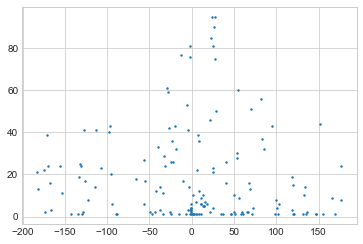

In [399]:
plt.scatter(grpedResults["daysRelative"],grpedResults["recordDate"], s=2)

In [400]:
grpedResults.to_csv('projects.csv')

In [366]:
after = grpedResults[grpedResults['daysRelative']>0]

In [367]:
before = grpedResults[grpedResults['daysRelative']< -10]

In [368]:
before.head()

,projectID,userID,daysRelative,eventDate,recordDate
0,23375,12809,-229,1,1
1,23375,12809,-227,2,2
2,23375,12809,-206,1,1
3,23375,12809,-177,1,1
4,23375,12809,-176,1,1


In [369]:
before.groupby(['userID']).count().reset_index().describe()

,userID,projectID,daysRelative,eventDate,recordDate
count,7.600000e+01,76.000000,76.000000,76.000000,76.000000
mean,7.517117e+05,29.434211,29.434211,29.434211,29.434211
std,7.269483e+05,35.260303,35.260303,35.260303,35.260303
min,5.360000e+02,1.000000,1.000000,1.000000,1.000000
25%,8.796975e+04,5.000000,5.000000,5.000000,5.000000
50%,5.147395e+05,14.500000,14.500000,14.500000,14.500000
75%,1.467487e+06,38.250000,38.250000,38.250000,38.250000
max,2.489562e+06,174.000000,174.000000,174.000000,174.000000


In [370]:
after.groupby(['userID']).count().reset_index().describe()

,userID,projectID,daysRelative,eventDate,recordDate
count,9.200000e+01,92.000000,92.000000,92.000000,92.000000
mean,9.635351e+05,33.771739,33.771739,33.771739,33.771739
std,8.505605e+05,48.438043,48.438043,48.438043,48.438043
min,5.360000e+02,1.000000,1.000000,1.000000,1.000000
25%,1.418322e+05,4.750000,4.750000,4.750000,4.750000
50%,7.830340e+05,11.500000,11.500000,11.500000,11.500000
75%,1.781872e+06,41.000000,41.000000,41.000000,41.000000
max,2.489562e+06,266.000000,266.000000,266.000000,266.000000
